## 4 - What is the longest match recorded in terms of duration? 

In [5]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

time_files = glob('../data/raw/*/time_[0-9]*.parquet')

In [6]:
# Load time data
time_columns=['match_id', 'period_1', 'period_2', 'period_3', 'period_4', 'period_5']
time_df = pd.concat([pd.read_parquet(f, columns=time_columns) for f in time_files], ignore_index=True)
time_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5
0,12077806,3520,3022,None,None,None
1,12077564,None,None,None,None,None
2,12077728,None,None,None,None,None
3,12077418,None,None,None,None,None
4,12077789,None,None,None,None,None


In [7]:
# Convert to timestamp periods to "seconds"
period_cols = [f'period_{i}' for i in range(1, 6)]
time_df[period_cols] = (
    time_df[period_cols]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .clip(upper=5959)  # First clip MM:SS format
    .apply(lambda x: (x // 100 * 60) + (x % 100))  # Convert to seconds
    .clip(upper=3600)  # Final clip in seconds
)
time_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5
0,12077806,2120.0,1822.0,0.0,0.0,0.0
1,12077564,0.0,0.0,0.0,0.0,0.0
2,12077728,0.0,0.0,0.0,0.0,0.0
3,12077418,0.0,0.0,0.0,0.0,0.0
4,12077789,0.0,0.0,0.0,0.0,0.0


In [8]:
# Calculate total duration 
time_df['total_duration_in_sec'] = time_df[[f'{col}' for col in period_cols]].sum(axis=1)
  
# Drop total duration less than 5 min
time_df = time_df[time_df['total_duration_in_sec'] > 300]
time_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5,total_duration_in_sec
0,12077806,2120.0,1822.0,0.0,0.0,0.0,3942.0
5,12078755,1643.0,1760.0,0.0,0.0,0.0,3403.0
7,12079486,2112.0,2621.0,0.0,0.0,0.0,4733.0
8,12079606,1283.0,1161.0,0.0,0.0,0.0,2444.0
14,12049618,1176.0,1104.0,0.0,0.0,0.0,2280.0


In [9]:
# Get longest match
result = time_df.nlargest(1, 'total_duration_in_sec').iloc[0]
hours, rem = divmod(result['total_duration_in_sec'], 3600)
mins, secs = divmod(rem, 60)

print(f"ID of the Longest Match: {result['match_id']}")
print(f"The Duration is: {hours:.0f}h {mins:02.0f}m {secs:02.0f}s")

ID of the Longest Match: 12130100.0
The Duration is: 2h 52m 01s


In [10]:
duration_stats = time_df['total_duration_in_sec'].describe()
print(duration_stats)

count    22561.000000
mean      3786.540490
std       1293.830702
min        707.000000
25%       2829.000000
50%       3537.000000
75%       4575.000000
max      10321.000000
Name: total_duration_in_sec, dtype: float64


In [11]:
max_per_period = {col: time_df.loc[time_df[col].idxmax(), ['match_id', col]] for col in period_cols}

print("Matches with longest duration per period:")
for period, data in max_per_period.items():
    total_sec = int(data[period])
    hours, rem = divmod(total_sec, 3600)
    mins, secs = divmod(rem, 60)
    print(f"{period}: Match ID {int(data['match_id'])}, Duration {hours}h {mins:02d}m {secs:02d}s")

Matches with longest duration per period:
period_1: Match ID 12078819, Duration 0h 59m 59s
period_2: Match ID 12078691, Duration 0h 59m 59s
period_3: Match ID 12054403, Duration 0h 59m 59s
period_4: Match ID 12077806, Duration 0h 00m 00s
period_5: Match ID 12077806, Duration 0h 00m 00s


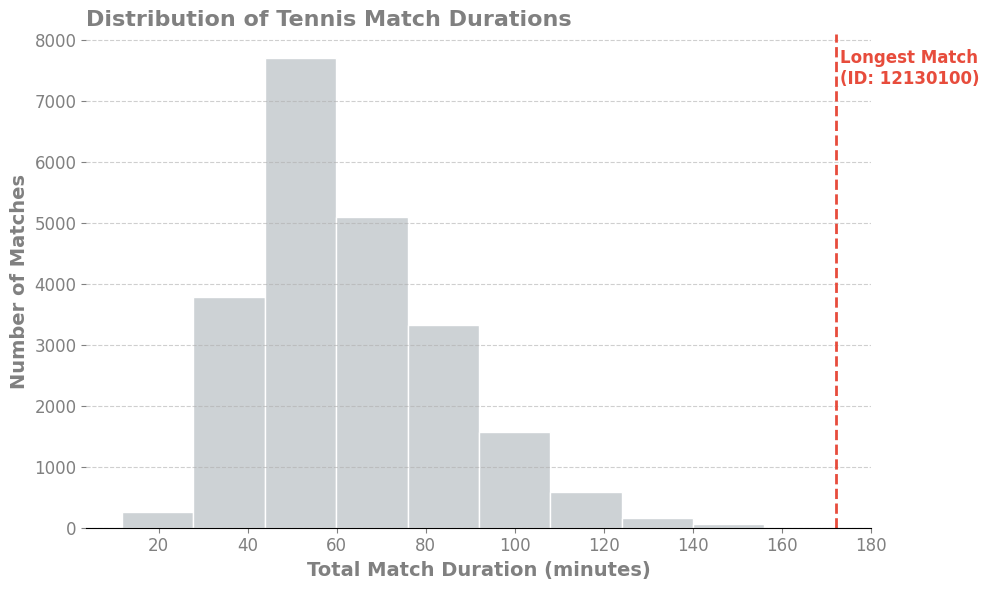

In [12]:
# Set colors
highlight_color = '#e74c3c'   # red
base_color = '#bdc3c7'        # gray

# Convert durations to minutes
time_df['duration_min'] = time_df['total_duration_in_sec'] / 60

# Identify longest match
max_duration = time_df['duration_min'].max()
longest_match_id = time_df.loc[time_df['duration_min'].idxmax(), 'match_id']

# Plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    time_df['duration_min'],
    bins=10,
    color=base_color,
    edgecolor='white'
)

# Add vertical line for longest match
plt.axvline(max_duration, color=highlight_color, linestyle='--', linewidth=2)
plt.text(
    x=max_duration + 1,
    y=ax.get_ylim()[1] * 0.9,
    s=f'Longest Match\n(ID: {longest_match_id})',
    color=highlight_color,
    fontsize=12,
    fontweight='bold'
)

# Styling
ax.set_title('Distribution of Tennis Match Durations', loc='left', weight='bold', color='gray', fontsize=16)
ax.set_xlabel('Total Match Duration (minutes)', weight='bold', color='gray', fontsize=14)
ax.set_ylabel('Number of Matches', weight='bold', color='gray', fontsize=14)

ax.tick_params(axis='x', colors='gray', labelsize=12)
ax.tick_params(axis='y', colors='gray', labelsize=12)
ax.grid(axis='y', linestyle='dashed', alpha=0.6)

# Remove spines
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('../data/output/figures/img4.png')
plt.show()
